In [15]:
"""
All necessary imports
NOTE: paper descriptors are the top 12 for magnetic moment, not formation energy.
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn

In [2]:
df = pd.read_csv('magneticmoment_Ef_data.csv', header=0)
mine = MINE(alpha=0.6, c=15) #a=.6 recommended by paper, c of more than 15 has no change in result

In [3]:
tmp = []
for j in range(len(df.columns)):
    if( not (isinstance(df.iloc[0][j], np.float64) or isinstance(df.iloc[0][j], np.int64)) ):
        tmp.append(df.columns[j])

#print(tmp)
df = df.drop(columns=tmp)
df = df.drop(columns=['magnetic_moment'])

#df.head(2)

In [4]:
y_axis = "formation_energy"
MIC_corrs = []

for j in range(len(df.columns)):
    
    mine.compute_score(df.iloc[:,j],df[y_axis]) 
    tmp_corr = mine.mic() 

    colname = df.columns[j]

    MIC_corrs.append((colname, tmp_corr))

corrdf = pd.DataFrame.from_records(MIC_corrs[1:], columns=['feature', 'correlation'])
corrdf = corrdf.dropna()
corrdf = corrdf.sort_values(by=['correlation'])
corrdf = corrdf.iloc[-13:-1]

mic_descriptors = list(corrdf["feature"])
print(mic_descriptors)

<ipython-input-4-f6060eb4c2b4>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mine.compute_score(df.iloc[:,j],df[y_axis])


['eaffinity_std', 'dipole_sum_dif', 'Born', 'dipole_avg', 'cs_OX', 'e_affinity_max_dif', 'nvalence_avg', 'dipole_max_dif', 'nvalence_std', 'cmpd_skew_d', 'num_d', 'cmpd_sigma_d']


In [5]:
#remove what we want to predict

labels = np.array(df['formation_energy'])

df = df.drop(columns=['formation_energy'])

#make dataframes for mic top 12, paper top 12, total df
mic_descriptors = mic_descriptors
paper_descriptors = ["Nup_mean", "cs_bob",  "nvalence_max_dif", "dipole_avg", 
                     "Nup_var", "nvalence_std", "nvalence_avg", "dipole_std_dif",  
                     "vdwradius_avg", "covalentrad_std_dif", "dipole_max_dif", "hardness_mean" ]
df_all = df
df_mic = df[mic_descriptors]
df_paper = df[paper_descriptors]
#----------------------------------------------------------------------
#get list of feature names for all, MIC top 12, paper top 12
#----------------------------------------------------------------------
feature_list_all = list(df_all.columns)

feature_list_mic = list(df_mic.columns)

feature_list_paper = list(df_paper.columns)

#get numpy array of all, mic, and paper features
features_all   = np.array(df_all)
features_mic   = np.array(df_mic)
features_paper = np.array(df_paper)

In [6]:
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets

def make_train_test_split(features, labels):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)
    return train_features, test_features, train_labels, test_labels 


In [7]:

def get_r_sq(predictions, test_labels):
    r_sq = metrics.r2_score(predictions, test_labels)
    return r_sq


In [8]:
def print_importances(rf, feature_list):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print("Most important variables:")
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:40]];

In [12]:

def make_graph(test_labels, predictions, r_sq, mode):
    x = test_labels
    y=predictions
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, test_labels)

    y2=(test_labels * slope + intercept)
    plt.scatter(x,y, color='c', label="data")
    plt.plot(x,y2, color='b', label="fitted line")

    plt.xlabel("True magnetic moment")
    plt.ylabel("Predicted")


    lab = "r^2=%.3f " % (r_sq)

    plt.plot([], [], ' ', label=lab )

    plt.legend()
    plt.title("Formation energy predictions using {} descriptors".format(mode))
    plt.show()

In [13]:
def run_and_graph(labels, features, feature_list, mode):
    train_features, test_features, train_labels, test_labels = make_train_test_split(features, labels)
    
    rf = RandomForestRegressor(n_estimators= 1000, random_state=42)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    r_sq = get_r_sq(predictions, test_labels)
    print("r squared value for", mode + ": ", round(r_sq, 2))
    #print_importances(rf, feature_list)
    make_graph(test_labels,predictions, r_sq, mode)

r squared value for All:  0.88


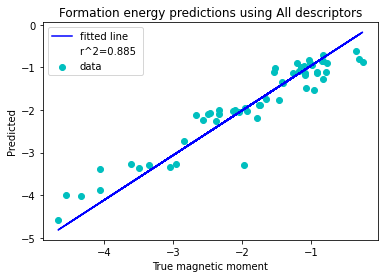

r squared value for MIC:  0.9


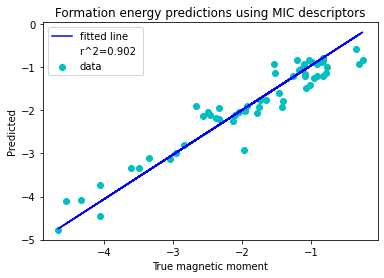

r squared value for Paper:  0.86


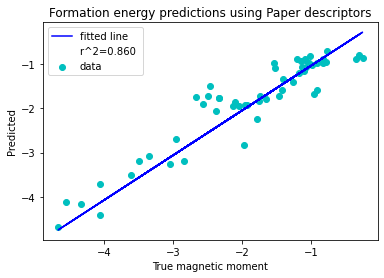

In [14]:
run_and_graph(labels, features_all, feature_list_all, "All")
run_and_graph(labels, features_mic, feature_list_mic, "MIC")
run_and_graph(labels, features_paper, feature_list_paper, "Paper")